In [1]:
import sqlite3; from bs4 import BeautifulSoup; import urllib.request as rq; import re

url = 'https://news.naver.com/main/main.naver?mode=LSD&mid=shm&sid1=102'
data = rq.urlopen(url)                          # 해당 url 파일로 open
data = data.read()                              # 파일을 바이너리형태로 처리
data = data.decode('euc-kr')                    # 파일 디코딩(해당 url은 euc-kr로 인코딩 되어있음)
data = BeautifulSoup(data, 'html.parser')       # html로 파싱하기
datas = data.select('.list_text a')             # selector를 이용해 필요한 클래스의 a태그만 가져오기
datas += data.select('.cluster_text a')

# 텍스트 추출
heads = []                          # 선택한 선택자 중 텍스트만 추출하여 담기 위한 리스트 변수 생성
for x in datas :
    if x.string :
        heads.append(x.string)      # 해당 태그의 텍스트만 추출하여 heads 리스트에 저장

# 텍스트 전처리
clean_text = ''                     # 전처리 후 텍스트를 담을 문자열 변수 생성
for x in heads :                    # 텍스트 전처리 시작
    x = re.sub('[\"\'\…,./“”‘’]|[-_=!?@#·$~%^&‥*()→↑<>]|[a-zA-Z]', ' ', x)
    x = re.sub("[][]", ' ', x)
    clean_text += x + ' '           # 전처리한 텍스트를 str형태로 저장

# 단어 추출
words = {}                          # 단어만 추출하여 저장할 딕셔너리 생성
for x in clean_text.split() :       # 공백을 기준으로 단어 슬라이싱
    if len(x) > 1 :                 # 단어 중 두 글자 이상의 단어만 추출
        words[x] = words.get(x,0) + 1   # 단어를 key값, 빈도수를 value값으로 저장 & 같은 단어 있을 시 value값 1씩 누적하여 저장

try :
    ## DB 작업
    conn = sqlite3.connect('word_count_db')    # DB 연동
    cursor = conn.cursor()                          # DB와 작업할 cursor 객체 생성

    # 테이블 생성 - num(인덱싱 용), word(단어), freq(빈도수)
    sql = "CREATE table if not exists word_count (num INTEGER PRIMARY KEY AUTOINCREMENT, word TEXT(20), freq INTEGER);"
    cursor.execute(sql)         # cursor 객체를 통해 sql문 실행

    for k, v in words.items() : # 추출한 각 단어와 빈도수를 테이블에 입력
        sql = f"INSERT INTO word_count(word, freq) VALUES ('{k}',{v})"
        cursor.execute(sql)
    conn.commit()
except Exception as e :         # 예외처리
    print('예외 발생! :',e)
    conn.rollback()
finally :                       # 사용한 객체 종료
    conn.close()
    cursor.close()



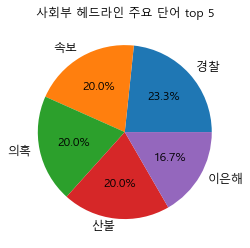

In [5]:
import sqlite3

from matplotlib import pyplot as plt, font_manager, rc

try :
    conn = sqlite3.connect('word_count_db')     # DB 연결
    cursor = conn.cursor()                      # DB 작업을 위한 cursor 객체 생성
    
    sql = "SELECT word, freq FROM word_count ORDER BY freq DESC"
    words = cursor.execute(sql).fetchmany(5)        # 빈도수 기준 내림차순으로 정렬한 데이터 중 5개 추출
except Exception as e :
    print('예외 발생! :',e)

word = []
count = []
for w, c in words :     # 튜플로 추출된 단어와 빈도수를 unpacking
    word.append(w)      # 단어를 list로 packing
    count.append(c)     # 빈도수를 list로 packing
    
# 단어가 한글이기 때문에, 한글 적용이 가능한 폰트 이름 가져오기
font_name = font_manager.FontProperties(fname='C:\Windows\Fonts\malgun.ttf').get_name()
rc('font',family=font_name)     # 폰트 이름으로 적용시키기

plt.pie(count, labels=word, autopct='%1.1f%%',textprops={'color' : 'black','fontsize':12})
plt.title('사회부 헤드라인 주요 단어 top 5',fontsize=12)    # pie차트의 제목 지정
plt.show()
